In [21]:
import sys
sys.path.append('../../..')

In [22]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from alns import ALNS, State
from alns.accept import RecordToRecordTravel
from alns.select import AlphaUCB
from alns.stop import MaxIterations

In [23]:
%matplotlib inline

In [24]:
SEED = 2345

# The permutation flow shop problem
In the PFSP, a set of jobs $N=\{1, \dots, n\}$ has to be processed on a set of machines $M = \{1, \dots, m\}$. Every job $j$ requires a processing time $p_{ij}$ on machine $i$. Moreover, all $n$ jobs have to be processed in the same order on every machine, and, the jobs follow the same machine order starting from machine $1$ and ending at machine $m$. The objective is to find a permutation of the jobs, denoting the order in which they are processed, such that the maximum completion time (the makespan) is minimized.

In this notebook, we demonstrate how to use ALNS to solve the permutation flow shop problem (PFSP), which is known to be NP-hard. In particular, we will implement the Iterated Greedy algorithm by Ruiz and Stützle (2007), which is a crossover between large neighborhood search and iterated local search.

This notebook covers some advanced features of the `alns` package, including passing `**kwargs` to `ALNS.iterate`, autofitting the acceptance criterion, and adding local search to greedy repair.

## Data
The [Taillard instances](http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/ordonnancement.html) are the most used benchmark instances for the permutation flow shop problem. We will use the `tai_50_20_8` instance, which consists of 50 jobs and 20 machines.

In [25]:
@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int # best known value
    processing_times: np.ndarray

with open("tai50_20_8.txt", 'r') as fi:
    lines = fi.readlines()
    
    n_jobs, n_machines, _, bkv, _ = [int(num) for num in lines[1].split()]
    processing_times = np.genfromtxt(lines[3:], dtype=int)
    data = Data(n_jobs, n_machines, bkv, processing_times)

## Preliminaries

In [26]:
def plot(schedule, name):
    n_machines, n_jobs = data.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - data.processing_times

    # Plot each job using its start and completion time
    cmap = cm.get_cmap("rainbow", n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, data.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"Schedule for {name}\n Makespan: {compute_makespan(schedule)}") 
    ax.set_ylabel(f"Machines")
    ax.set_xlabel(f"Time")
#     ax.set_yticklabels(range(instance.n_machines + 1))

    plt.show()

def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(data.processing_times.shape, dtype=int)

    for pos, job in enumerate(schedule):
        for machine in range(data.n_machines):
            prev_job = (
                completion[machine, schedule[pos - 1]] if pos != 0 else 0
            )
            prev_machine = completion[machine - 1, job] if machine != 0 else 0
            processing = data.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]

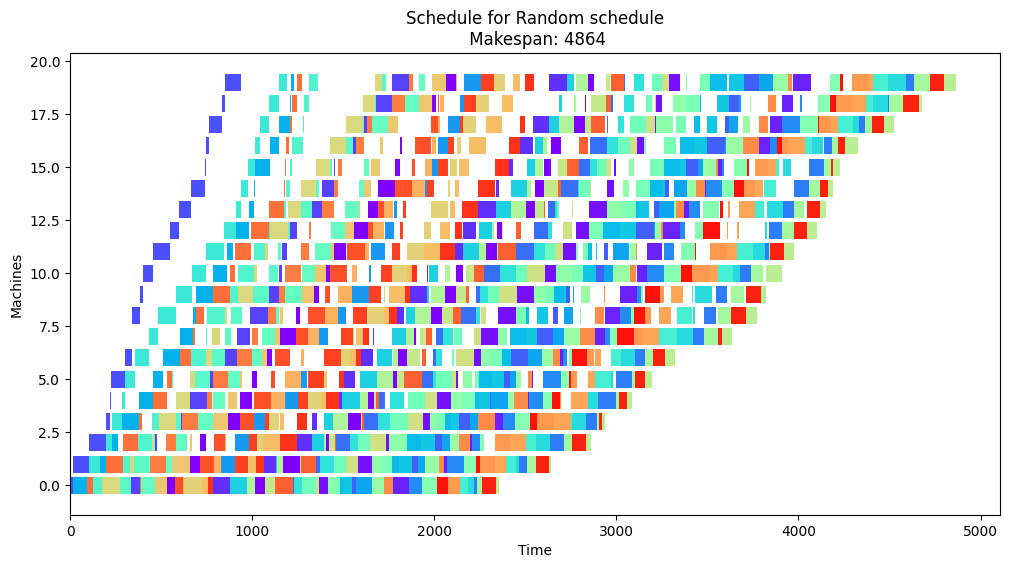

In [51]:
dummy = list(range(50))
rnd.shuffle(dummy)

plot(dummy, 'Random schedule')

In [28]:
def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
    """
    Computes the partial makespans when inserting a job in the schedule.
    O(nm) using Taillard acceleration.

    [1] Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.
    """
    k = len(schedule) + 1
    m = data.processing_times.shape[0]
    p = data.processing_times

    # Earliest completion times of job pi(j) on machine i before inserting the new job
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]

In [44]:
class Solution(State):
    def __init__(self, schedule: List[int], unassigned: Optional[List[int]] = None):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []
        self._makespan = None

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)

## Destroy operators
We implement two destroy operators: a random job removal operator, and an adjacent job removal operator. Both destroy operators rely on the `n_remove` parameter, which should inferred from the `**kwargs` argument. We will show later how to pass this argument to ALNS.

In [30]:
def random_removal(state: Solution, rnd_state, **kwargs) -> Solution:
    """
    Randomly remove a number jobs from the solution. The default number of jobs
    to remove is 2. If `n_remove` is passed as keyword argument, use that value
    instead.
    """
    destroyed = deepcopy(state)

    for job in rnd_state.choice(
        data.n_jobs, kwargs.get("n_remove", 2), replace=False
    ):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed

In [31]:
def adjacent_removal(state: Solution, rnd_state, **kwargs) -> Solution:
    """
    Randomly remove a number adjacent jobs from the solution. The default
    number of jobs to remove is 2. If `n_remove` is passed as keyword argument,
    use that value instead.
    """
    destroyed = deepcopy(state)
    n_remove = kwargs.get("n_remove", 2)

    start = rnd_state.randint(data.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed

## Repair operators and local search
We first introduce the greedy repair operator. The NEH heuristic, i.e., to order jobs in non-decreasing order of processing times, is also very effective for the greedy repair operator

In [32]:
def greedy_repair(state: Solution, rnd_state, **kwargs) -> Solution:
    """
    Greedily insert the unassigned jobs back into the schedule. The jobs are
    inserted in non-dcreasing order of total processing times.
    """
    state.unassigned.sort(key=lambda j: sum(data.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state

In iterated greedy, the repair step is followed by a local search neighborhood. We define another function that includes this step:

In [33]:
def greedy_repair_then_local_search(state: Solution, rnd_state, **kwargs):
    """
    Greedily insert the unassigned jobs back into the schedule. Apply local
    search using the insertion neighborhood afterwards.
    """
    state = greedy_repair(state, rnd_state, **kwargs)
    local_search(state, **kwargs)
    return state


def local_search(solution: Solution, **kwargs):
    """
    Improves the current solution in-place using the insertion neighborhood.
    """
    improved = True

    while improved:
        improved = False
        current = solution.objective()

        for job in rnd.choice(
            solution.schedule, len(solution.schedule), replace=False
        ):
            solution.remove(job)
            solution.opt_insert(job)

            if solution.objective() < current:
                improved = True
                current = solution.objective()
                break

## Initial solution

In [34]:
def NEH(processing_times: np.ndarray) -> Solution:
    """
    Schedules jobs in decreasing order of the total processing times.

    [1] Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.
    """
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution

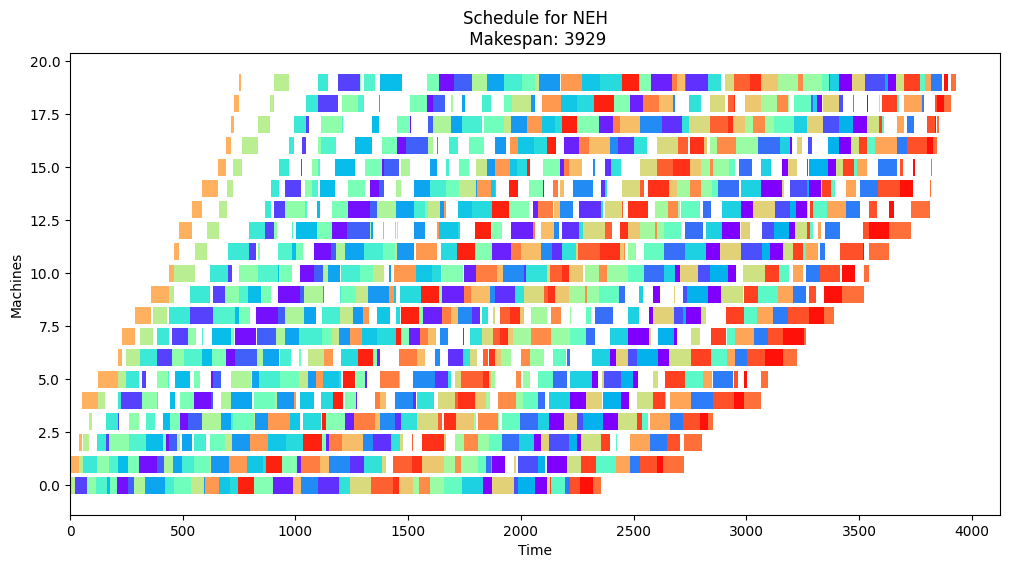

In [35]:
plot(NEH(data.processing_times).schedule, "NEH")

## Heuristic solution

In [39]:
alns = ALNS(rnd.RandomState(SEED))

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(adjacent_removal)

alns.add_repair_operator(greedy_repair)
alns.add_repair_operator(greedy_repair_then_local_search)

In [45]:
ITERS = 300

init = NEH(data.processing_times)
select = AlphaUCB(
    scores=[5, 2, 1, 0.5],
    alpha=0.10,
    num_destroy=len(alns.destroy_operators),
    num_repair=len(alns.repair_operators),
)
accept = RecordToRecordTravel.autofit(init.objective(), 0.03, 0, ITERS)
stop = MaxIterations(ITERS)

result = alns.iterate(init, select, accept, stop)

In [46]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - data.bkv) / bkv

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bkv}.")

Best heuristic objective is 3823.
This is 3.1% worse than the optimal solution, which is 3709.


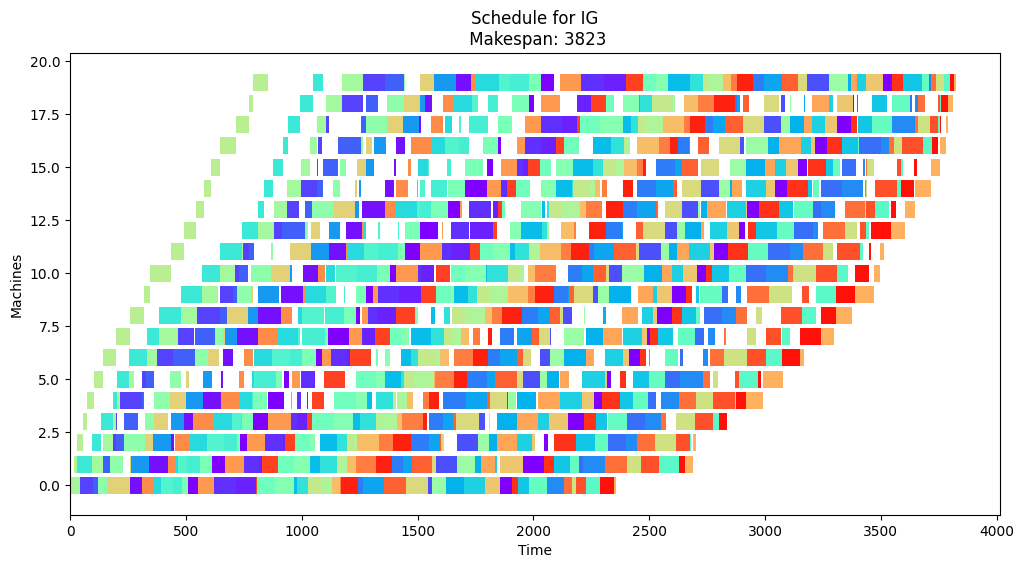

In [47]:
plot(result.best_state.schedule, "IG")

## Conclusions
In this notebook, we implemented the iterated greedy algorithm to solve the permutation flow shop problem. We showed a few advanced features in ALNS, including:
- Adding local search to repair procedures
- Passing `**kwargs` to operators
- Autofitting acceptance criteria